# Introduction

### Introduction

Heart disease remains one of the foremost causes of mortality worldwide, encompassing a range of conditions such as coronary artery disease, heart attacks, and heart failure. Understanding and mitigating heart disease is crucial due to its significant impact on public health and healthcare systems.

This analysis utilizes heart disease datasets from multiple institutions, providing a comprehensive view of various factors contributing to heart disease. Key variables in these datasets include:

- **Age**: Age of the patient.
- **Sex**: Gender of the patient.
- **Chest Pain Type (cp)**: Types of chest pain experienced.
- **Resting Blood Pressure (trestbps)**: Blood pressure at rest.
- **Serum Cholesterol (chol)**: Cholesterol levels in the blood.
- **Fasting Blood Sugar (fbs)**: Blood sugar levels after fasting.
- **Resting Electrocardiographic Results (restecg)**: Results from resting ECG.
- **Maximum Heart Rate Achieved (thalach)**: Peak heart rate during exercise.
- **Exercise-Induced Angina (exang)**: Presence of angina induced by exercise.
- **ST Depression (oldpeak)**: Depression in ST segment induced by exercise.
- **Slope of Peak Exercise ST Segment (slope)**: Slope of the ST segment during peak exercise.
- **Number of Major Vessels (ca)**: Number of major vessels colored by fluoroscopy.
- **Thalassemia (thal)**: Blood disorder status.
- **Heart Disease (num)**: Signifying the severity of Heart Disease from 0-4.

The datasets vary in completeness; the Cleveland dataset is complete with no missing values, while the Switzerland and Hungary datasets contain many missing values, particularly in the slope,fbs, ca, and thal categories. The va falls into its own camp, with large chunks of data missing. This analysis aims to explore these variables to identify patterns and factors associated with heart disease, ultimately contributing to better diagnosis and treatment strategies.

In [74]:
import pandas as pd
data = pd.read_csv('processed.cleveland.data')
data.head()


,63.0,1.0,1.0.1,145.0,233.0,1.0.2,2.0,150.0,0.0,2.3,3.0,0.0.1,6.0,0
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


## Cleveland Data Preprocessing

The dataset lacked column names, so I labeled the columns with the associated names. Additionally, I decided to make 'num' binary where 0 is no heart disease and 1 is any heart disease. I felt that this binary variable captured the project intentions more than having values from 0-4. Having a binary heart disease column also simplifies classification. Finally, I made 'ca' and 'thal' numeric for random forest classification.

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
# renaming the column names in order to make it easier to understand the dataframe/pull stuff
data.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "num"
]
#adding on a column where 0 is no heart disease and 1-4 is heart disease
conditions = [data['num']==0, data['num'] >0]
assignments = [0,1]

data['binary disease'] = np.select(conditions, assignments)

#making object columns numeric
label_encoder = LabelEncoder()

# Encode 'ca' and 'thal' columns
data['ca'] = label_encoder.fit_transform(data['ca'])
data['thal'] = label_encoder.fit_transform(data['thal'])

data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,binary disease
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3,0,2,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2,2,1,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0,0,0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0,0,0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0,0,0,0


## Distribution Class Plot

I decided to make a simple plot to understand the distribution of the classes within the dataset and to see if there were major class imbalance.

Text(0.5, 1.0, 'Distribution of Heart Disease over age')

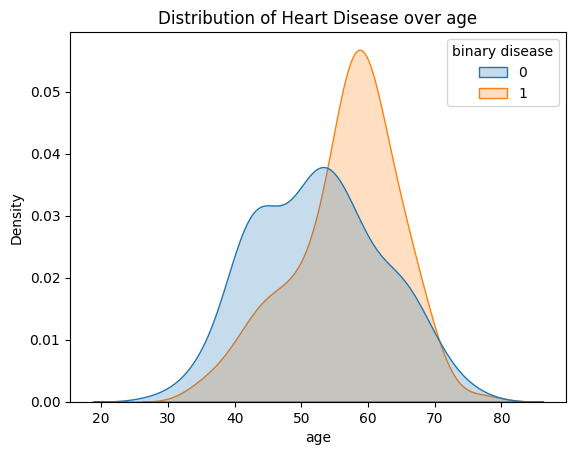

In [8]:
import matplotlib.pyplot as mpl
import seaborn as sns
#plot to help understand the class imbalance
sns.kdeplot(x='age', hue = 'binary disease', multiple = 'layer',
            common_norm = False, fill = True, data = data)
mpl.title("Distribution of Heart Disease over age")

# Random Forest Model (Cleveland Data)
I fitted a Random Forest Model, as this supervised learning model is good at handleing both categorical and numeric features, is robust against overfitting, and can handle complex non-linear relationships between the features and the target variable. Finally, I thought a randomforest would also be helpful in identifying feature importance. In the model, I tuned parameters such as the number of trees, the max_depth of each tree, the max_features at each split and many more with a tuneing grid in order to find the best parameters to contruct a random forest. These parameters led to an accuracy of 83% and a specificity of 88%. The high specificity suggests that the model is good at classifiying instances of heart disease correctly, the main goal of the model.

In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from tabulate import tabulate
from IPython.display import display, HTML

master_metrics_df = pd.DataFrame(columns=['metric', 'Cleveland_rf', 'indp_rf', 'big_rf', 'xgboost'])

#random forest with heartdisease dataframe
filter_data = data.drop('num', axis = 1) #removing num in order to make binary disease only y

X = filter_data.drop('binary disease', axis = 1)
y = filter_data['binary disease']

rf = RandomForestClassifier(n_estimators=100, random_state=54, max_depth = 7, min_samples_split = 2,
                           min_samples_leaf = 6, max_features = 'sqrt', bootstrap = True, criterion = 'entropy')

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to accumulate metrics
accuracy_list = []
precision_list = []
recall_list = []
specificity_list = []
f1_score_list = []
confusion_matrices = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)

     # Append metrics to lists
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision)
    recall_list.append(recall)
    specificity_list.append(specificity)
    f1_score_list.append(f1_score)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_specificity = np.mean(specificity_list)
avg_f1_score = np.mean(f1_score_list)

# Calculate average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)

# Create a DataFrame for the average confusion matrix
cm_df = pd.DataFrame(avg_cm, 
                     index=['True: No Disease', 'True: Disease'], 
                     columns=['Pred: No Disease', 'Pred: Disease'])

# Print the formatted average confusion matrix
print("Average Confusion Matrix Across All Folds:")
display(HTML(cm_df.to_html()))

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score'],
    'Value': [avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score]
})

# Alternatively, display the DataFrame using IPython display for Jupyter Notebook
display(HTML(metrics_df.to_html(index=False)))

#{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 7, 
#'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2, 
# 'n_estimators': 100}
master_metrics_df['Cleveland_rf'] = metrics_df['Value']

Average Confusion Matrix Across All Folds:


,Pred: No Disease,Pred: Disease
True: No Disease,28.8,3.8
True: Disease,6.4,21.4


Metric,Value
Accuracy,0.831257
Precision,0.851982
Recall,0.770106
Specificity,0.883523
F1-Score,0.808366


## Hungary and Switzerland Data Preprocessing

After creating the original randomforest, I decided to see if imputeing the missing values for the Hungary and Switzerland data before running a model on the combined set would lead to better results. Preprocessing these datasets was largely the same, except since the data were loaded as .data files, NA values were written in as '?'. These '?' made any column with them by default an object column rather than a numeric column. In order to make the data ready for imputation, I replaced the '?' with NA values and then coerced the columns to numeric ones. Finally, I imputed the datasets with a randomforest imputations, replacing the NAs with estimates of what the true values might be. The VA dataset was left out of these models due to a higher occurence of NA values and for the fact that it dragged down the accuracy/sensitivity of the models when it was included in the training/test data.

In [47]:
# Import necessary libraries
import warnings   
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

#Loading datasets
warnings.filterwarnings('ignore')
switz_data = pd.read_csv('processed.switzerland.data')
hungary_data = pd.read_csv('processed.hungarian.data')

#Rename columns
switz_data.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "num"]
hungary_data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "num"]

#replacing "?" with NAs in order to make imputation possible
hungary_data.replace('?', np.nan, inplace=True)
switz_data.replace('?', np.nan, inplace=True)

hungary_data = hungary_data.apply(pd.to_numeric, errors='coerce')
switz_data = switz_data.apply(pd.to_numeric, errors='coerce')


#Initialize LabelEncoder
label_encoder = LabelEncoder()

#adding binary disease
conditions = [switz_data['num'] == 0, switz_data['num'] > 0]
assignments = [0, 1]
switz_data['binary disease'] = np.select(conditions, assignments)

conditions = [hungary_data['num'] == 0, hungary_data['num'] > 0]
hungary_data['binary disease'] = np.select(conditions, assignments)

# Remove 'num'
hungary_data_filter = hungary_data.drop('num', axis=1)
switz_data_filter = switz_data.drop('num', axis=1)

# Define the IterativeImputer with RandomForestRegressor as the estimator
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=542),
    max_iter=10,
    random_state=542
)

# Impute the Hungary/Switzdata
hungary_data_imputed = rf_imputer.fit_transform(hungary_data_filter)
switz_data_imputed = rf_imputer.fit_transform(switz_data_filter)

# Convert the results back to DataFrame
hungary_data_imputed = pd.DataFrame(hungary_data_imputed, columns=hungary_data_filter.columns)
switz_data_imputed = pd.DataFrame(switz_data_imputed, columns=switz_data_filter.columns)


## Imputation Justification

I decided to randomly replace 30 values from the Cleveland dataset in order to see how accurate the imputations were and if they were worth using in order to create a new randomforest model. In order to not run into errors of dividing by 0, I decided to shift all of the values in the dataset by 1 before making the imputations. After comparing the actual values with the artificially removed ones, I found my imputations to be an average displacement of 25% from the original values. I decided to compare these results with imputing the entire dataset at once rather than imputing Switzerland and Hungary data independently. I found this method to yield an average displacement of 7% as compared with the 25%.

In [11]:
import warnings
warnings.filterwarnings('ignore')   
#imputation justification/accurracy
shift_data = filter_data + 1 #deal with 0s for percent diff calculation 
num_rows = filter_data.shape[0]
num_columns = filter_data.shape[1]

#taking a random 10% of all of the rows and putting in NAs

num_cells = num_rows//10

# Get indices for NaN vals
#np.random.seed(542)
impute_acc = []
na_data = shift_data.copy()
for i in range(10):
    rows = np.random.choice(num_rows, num_cells, replace=False)
    columns = np.random.choice(num_columns, num_cells, replace=True)
    
    # Replace the selected values with NaN
    replaced_indices = set()

    for j in range(num_cells):
        na_data.iloc[rows[j], columns[j]] = np.nan
        replaced_indices.add((rows[j], columns[j]))
    
    #impute the NAs
    na_data_imputed = rf_imputer.fit_transform(na_data)
    na_data_imputed = pd.DataFrame(na_data_imputed, columns=na_data.columns)
    
    #check the average % difference of the imputed values from the actual values
    actual_value = 0
    predicted_value = 0
    perc_diff = []
    for (row, column) in replaced_indices:
        actual_value = shift_data.iloc[row, column]
        predicted_value = na_data_imputed.iloc[row,column]       
        perc_diff.append(abs(actual_value - predicted_value)/actual_value) #perc diff
    
    impute_acc.append(np.mean(perc_diff)) 
print(np.mean(impute_acc)) # 25% accuracy

0.2510446675348485


In [16]:
import warnings
warnings.filterwarnings('ignore')
#is imputing better with the whole dataset at once?
na_data = shift_data.copy()

#shift to avoid /0 errors
hungary_shift = hungary_data_filter + 1
switz_shift = switz_data_filter + 1 

impute_acc = []
for i in range(10):
    #making random indeces for NAs
    rows = np.random.choice(num_rows, num_cells, replace=False)
    columns = np.random.choice(num_columns, num_cells, replace=True)
    
    #inserting NAs at random indeces
    for j in range(num_cells):
        na_data.iloc[rows[j], columns[j]] = np.nan
        replaced_indices.add((rows[j], columns[j]))
        
    big_heart = pd.concat([na_data, hungary_shift, switz_shift], ignore_index=True)
    
    big_heart_imputed = rf_imputer.fit_transform(big_heart)
    big_heart_imputed = pd.DataFrame(big_heart_imputed, columns=big_heart.columns)
    
    actual_value = 0
    predicted_value = 0
    perc_diff = []
    
    for (row, column) in replaced_indices:
        actual_value = shift_data.iloc[row, column]
        predicted_value = big_heart_imputed.iloc[row,column]
        perc_diff.append(abs(actual_value - predicted_value)/actual_value) #perc diff
    
    impute_acc.append(np.mean(perc_diff)) #18% difference on avg
print(np.mean(impute_acc)) #0.21%


0.06534389657743367


## Results
The RandomForest models with imputed datasets performed remarkably better than the Cleveland dataset, but between the two imputed datasets, though independent imputations had a higher displacement, the random forest utilizing the independent imputations performed better. This may be due to a variety of factors, however I believe that it is because imputations become more variable as more imputations are added to a dataset. Additionally, imputing all of the datasets together could have minimized factors that made the datasets different. For example, maybe imputing the datasets separately allows for country discrepancies in heart disease to be accounted for while imputing them together eliminates some of the varience between the datasets. Overall, the independently imputed random forest model performed the best, with an accuracy of 88.1% and a specificity of 87.7%. 


## Independently Imputed Random Forest

In [59]:
warnings.filterwarnings('ignore')
# Concatenate the datasets
heart_disease_data = pd.concat([hungary_data_imputed, switz_data_imputed, filter_data], ignore_index=True)

# Define features and target
X = heart_disease_data.drop('binary disease', axis=1)
y = heart_disease_data['binary disease']

# Initialize the RandomForestClassifier
rf_big = RandomForestClassifier(n_estimators=100, random_state=542, max_depth=10, min_samples_split=2,
                                min_samples_leaf=6, max_features='sqrt', bootstrap=True, criterion='gini')

# Number of bootstrap samples
n_bootstrap_samples = 100

# Initialize variables to accumulate metrics
accuracy_list = []
precision_list = []
recall_list = []
specificity_list = []
f1_score_list = []
confusion_matrices = []

# Perform .632 bootstrapped validation
for _ in range(n_bootstrap_samples):
    # Bootstrap sampling
    bootstrap_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))
    
    X_train, y_train = X.iloc[bootstrap_indices], y.iloc[bootstrap_indices]
    X_test, y_test = X.iloc[oob_indices], y.iloc[oob_indices]
    
    # Train the model
    rf_big.fit(X_train, y_train)
    
    # Make predictions on OOB samples
    y_pred = rf_big.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Append metrics to lists
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision)
    recall_list.append(recall)
    specificity_list.append(specificity)
    f1_score_list.append(f1_score)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_specificity = np.mean(specificity_list)
avg_f1_score = np.mean(f1_score_list)

# Calculate average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)

# Create a DataFrame for the average confusion matrix
cm_df = pd.DataFrame(avg_cm, 
                     index=['True: No Disease', 'True: Disease'], 
                     columns=['Pred: No Disease', 'Pred: Disease'])

# Print the formatted average confusion matrix
display(HTML(cm_df.to_html()))

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score'],
    'Value': [avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score]
})
display(HTML(metrics_df.to_html(index=False)))
master_metrics_df['Metric'] = metrics_df['Metric']
master_metrics_df['indp_rf'] = metrics_df['Value']

,Pred: No Disease,Pred: Disease
True: No Disease,114.69,16.15
True: Disease,15.20,117.29


Metric,Value
Accuracy,0.880919
Precision,0.879643
Recall,0.885546
Specificity,0.876936
F1-Score,0.881838


## Imputations all Together Random Forest

In [60]:
warnings.filterwarnings('ignore')
from scipy.stats import bootstrap
from sklearn.utils import resample

#Making a model with different full dataset imputation instead
big_heart = pd.concat([hungary_data_filter, switz_data_filter, filter_data])
big_heart_imputed = rf_imputer.fit_transform(big_heart)
big_heart_imputed = pd.DataFrame(big_heart_imputed, columns=big_heart.columns)

X = big_heart_imputed.drop('binary disease', axis = 1)
y = big_heart_imputed['binary disease']

rf_big2 = RandomForestClassifier(
    n_estimators=100, random_state=542, max_depth=10,
    min_samples_split=2, min_samples_leaf=7, max_features='sqrt',
    bootstrap=True, criterion='entropy'
)

# Number of bootstrap samples
n_bootstrap_samples = 100

# Initialize variables to accumulate metrics
accuracy_list = []
precision_list = []
recall_list = []
specificity_list = []
f1_score_list = []
confusion_matrices = []

# Perform .632 bootstrapped validation
for _ in range(n_bootstrap_samples):
    # Bootstrap sampling
    bootstrap_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))
    
    X_train, y_train = X.iloc[bootstrap_indices], y.iloc[bootstrap_indices]
    X_test, y_test = X.iloc[oob_indices], y.iloc[oob_indices]
    
    # Train the model
    rf_big2.fit(X_train, y_train)
    
    # Make predictions on OOB samples
    y_pred = rf_big2.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Append metrics to lists
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision)
    recall_list.append(recall)
    specificity_list.append(specificity)
    f1_score_list.append(f1_score)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_specificity = np.mean(specificity_list)
avg_f1_score = np.mean(f1_score_list)

# Calculate average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)

# Create a DataFrame for the average confusion matrix
cm_df = pd.DataFrame(avg_cm, 
                     index=['True: No Disease', 'True: Disease'], 
                     columns=['Pred: No Disease', 'Pred: Disease'])

# Print the formatted average confusion matrix
display(HTML(cm_df.to_html()))

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score'],
    'Value': [avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score]
})

# Alternatively, display the DataFrame using IPython display for Jupyter Notebook
display(HTML(metrics_df.to_html(index=False)))

master_metrics_df['big_rf'] = metrics_df['Value']
    

,Pred: No Disease,Pred: Disease
True: No Disease,115.49,15.10
True: Disease,19.05,113.02


Metric,Value
Accuracy,0.870015
Precision,0.882628
Recall,0.855976
Specificity,0.884632
F1-Score,0.868545


## XGBoost Model

The accuracy and specificity of this model were similar to the independently imputed random forest model. The accuracy of the xgboost model is 88.4%, with its specificity being 88.3%. Ultimately the difference in accuracy can easily be attributed to random chance, suggesting that neither model is significantly better than the other. I tuned parameters such as the learning rate, number of trees, the max depth of the tree and many more.

In [61]:


from xgboost import XGBClassifier
# XGBoost model
X = heart_disease_data.drop('binary disease', axis = 1)
y = heart_disease_data['binary disease']

xgb_model = XGBClassifier(
    learning_rate=0.013221539453386388,
    n_estimators=219,
    max_depth=7,
    min_child_weight=4,
    subsample=0.7021779437835471,
    colsample_bytree=0.9691526636027585,
    gamma=0.00017354039978408065,
    reg_alpha=0.8965836059624231,
    reg_lambda=1.5910820434857533
)
#Best parameters: {'learning_rate': 0.013221539453386388, 'n_estimators': 219,
#  'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.7021779437835471,
#  'colsample_bytree': 0.9691526636027585, 'gamma': 0.00017354039978408065, 
# 'reg_alpha': 0.8965836059624231, 'reg_lambda': 1.5910820434857533}
# Number of bootstrap samples
n_bootstrap_samples = 100

# Initialize variables to accumulate metrics
accuracy_list = []
precision_list = []
recall_list = []
specificity_list = []
f1_score_list = []
confusion_matrices = []

# Perform .632 bootstrapped validation
for _ in range(n_bootstrap_samples):
    # Bootstrap sampling
    bootstrap_indices = np.random.choice(range(len(X)), size=len(X), replace=True)
    oob_indices = list(set(range(len(X))) - set(bootstrap_indices))
    
    X_train, y_train = X.iloc[bootstrap_indices], y.iloc[bootstrap_indices]
    X_test, y_test = X.iloc[oob_indices], y.iloc[oob_indices]
    
    # Train the model
    xgb_model.fit(X_train, y_train)
    
    # Make predictions on OOB samples
    y_pred = xgb_model.predict(X_test)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Append metrics to lists
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision)
    recall_list.append(recall)
    specificity_list.append(specificity)
    f1_score_list.append(f1_score)

# Calculate average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_specificity = np.mean(specificity_list)
avg_f1_score = np.mean(f1_score_list)

# Calculate average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)

# Create a DataFrame for the average confusion matrix
cm_df = pd.DataFrame(avg_cm, 
                     index=['True: No Disease', 'True: Disease'], 
                     columns=['Pred: No Disease', 'Pred: Disease'])

# Print the formatted average confusion matrix
display(HTML(cm_df.to_html()))

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score'],
    'Value': [avg_accuracy, avg_precision, avg_recall, avg_specificity, avg_f1_score]
})

# Alternatively, display the DataFrame using IPython display for Jupyter Notebook
display(HTML(metrics_df.to_html(index=False)))
master_metrics_df['xgboost'] = metrics_df['Value']

,Pred: No Disease,Pred: Disease
True: No Disease,116.98,15.55
True: Disease,15.07,116.67


Metric,Value
Accuracy,0.884160
Precision,0.882825
Recall,0.885839
Specificity,0.882952
F1-Score,0.883791


# Importance Features of the Independently Imputed Random Forest

Feature,Importance
ca,0.222399
cp,0.219272
thalach,0.091569
exang,0.076108
oldpeak,0.072542
chol,0.071245
slope,0.071030
age,0.055596
thal,0.046951
trestbps,0.030345


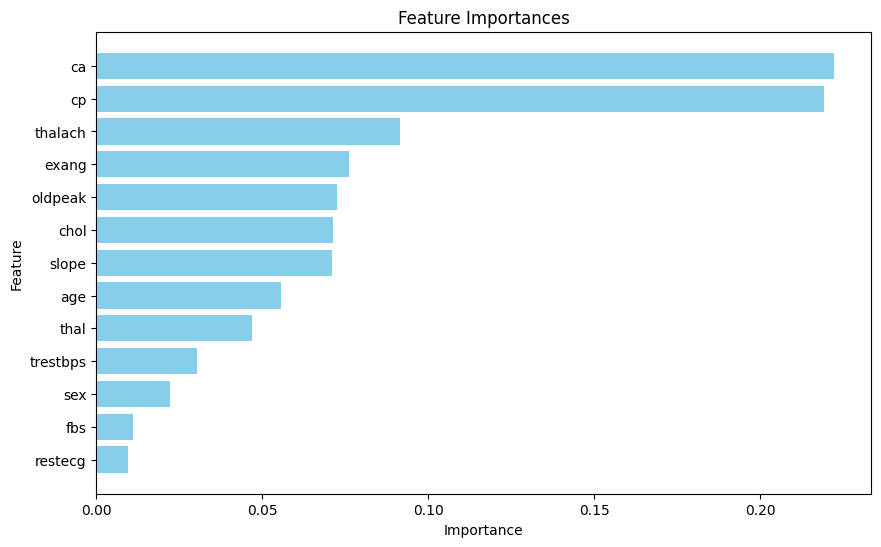

In [62]:
#feature importance
feature_importances = rf_big2.feature_importances_

feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

display(HTML(feature_importances_df.to_html(index=False)))

# Plot the feature importances
mpl.figure(figsize=(10, 6))
mpl.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
mpl.xlabel('Importance')
mpl.ylabel('Feature')
mpl.title('Feature Importances')
mpl.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
mpl.show()

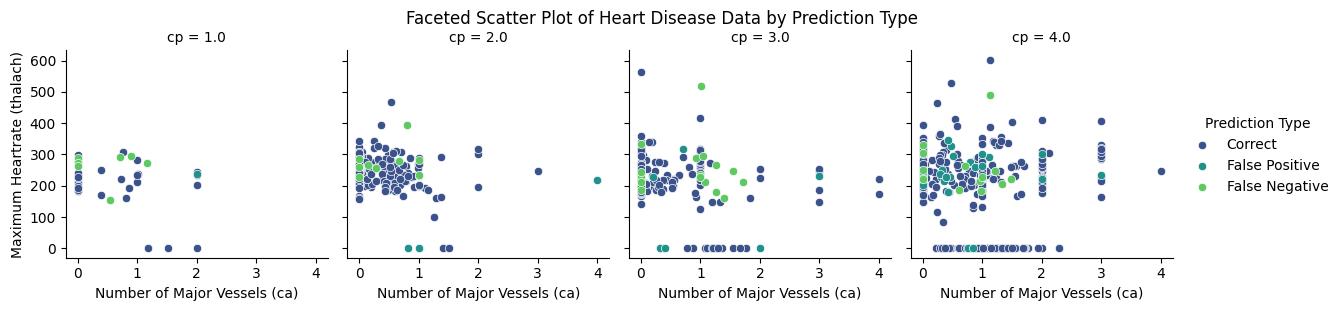

In [64]:
from mpl_toolkits.mplot3d import Axes3D
#Missclassification plot Plot
y_pred = rf_big2.predict(X)
big_heart_imputed['prediction_type'] = np.where(y == y_pred, 0, 
                                                  np.where((y == 0) & (y_pred == 1), 1, 2))
# Create a pivot table for the heatmap
heatmap_data = big_heart_imputed.pivot_table(index='cp', columns='ca', values='prediction_type', aggfunc='mean')

# Create a FacetGrid for the scatter plot
sca_plot = sns.FacetGrid(big_heart_imputed, col="cp", hue="prediction_type", sharex=True, sharey=True, palette="viridis")

# Map the scatter plot to the FacetGrid
sca_plot.map(sns.scatterplot, "ca", "chol")

# Add a legend
sca_plot.add_legend(title="Prediction Type", labels=["Correct", "False Positive", "False Negative"])

# Set axis labels and title
sca_plot.set_axis_labels("Number of Major Vessels (ca)", "Maximum Heartrate (thalach)")
sca_plot.fig.suptitle("Faceted Scatter Plot of Heart Disease Data by Prediction Type", y=1.02)

# Show plot
mpl.show()

In [68]:
master_metrics_df = master_metrics_df.drop('metric', axis = 1)
display(HTML(master_metrics_df.to_html(index=False)))

Cleveland_rf,indp_rf,big_rf,xgboost,Metric
0.831257,0.880919,0.870015,0.884160,Accuracy
0.851982,0.879643,0.882628,0.882825,Precision
0.770106,0.885546,0.855976,0.885839,Recall
0.883523,0.876936,0.884632,0.882952,Specificity
0.808366,0.881838,0.868545,0.883791,F1-Score


# Conclusions

Though I couldn't find a conclusive way to calculate the cost of a false positive as compared with a false negative, it can be assumed that a false negative is more costly than a false negative and future models should calibrate their class weights to account for that cost imbalance. The most important features the best random forest model uses to classifiy Heart Disease are Chest Pain Type (cp), The number of major blood vessels colored by fluroscopy (ca), and the maximum heart-rate achieved (thalach). Additionally, the xgboost model and the independently imputed random forest model classify heart disease more accurately than they classify no heart disease. This makes sense as the dataset contains more instances of heart disease as compared with healthy cases. Furthermore, False negatives seem to occur when the number of major vessels colored by fluoroscopy is 0. False positives occur the most when chest pain is type 4. This suggests that there's an important variable that the model is not accounting for such as genetics or some other risk factor. Finally, the xgboost model and the independently imputed random forest models outperformed all of the other models in terms of accuracy and specificity.

Data Donaters:
   1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
   2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
   3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
   4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: